Disciplina: Aprendizagem de Máquina

Período: 2025.1

Professor: César Lincoln Cavalcante Mattos

Aluno: Davi Teixeira Silva

# Lista 5 - SVM e comitês de modelos

## Questão 1

Considere o conjunto de dados disponível em californiabin.csv, organizado em 9 colunas, sendo as 8 primeiras colunas os atributos e a última coluna a saída. Os 8 atributos são usados na predição de preços de casas em distritos da Califórnia na década de 1990. A saída é binária: 0, para abaixo da mediana dos preços; 1, para acima da mediana dos preços. Maiores detalhes sobre os dados podem ser conferidos em https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset.

a) Considerando uma divisão de 80% dos padrões para treinamento e 20% para teste, avalie modelos de classificação binária nos dados em questão. Para tanto, use as abordagens abaixo:

– SVM: Escolha um kernel RBF e use grid-search para ajustar os hiperparâmetros C (valores 2^-5, 2^-3, 2^-1, ... , 2^11, 2^13, 2^15) e γ (valores 2^-15, 2^-13, 2^-11, ... , 2^1, 2^2, 2^3).

– Random Forest: Use grid-search para ajustar o número de classificadores base (valores 10, 20, . . ., 180, 190, 200) e a máxima profundidade (max depth valores 4, 6, 8, 10 ou máxima).

b) Para cada modelo campeão, reporte os hiperparâmetros selecionados e as métricas de acurácia, revocação, precisão e F1-score nos dados de teste. Plote também a curva ROC e a curva Precision-Recall, reportando as áreas sob as curvas, i.e., AUROC e AUPRC.

Observações:
- Use validações cruzadas em 10 folds no interior do grid-search.
- Não esqueça de retreinar o modelo final com os hiperparâmetros otimizados usando tanto os dados de treino quanto de validação.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# Carregar os dados
data = np.genfromtxt('californiabin.csv', delimiter=',')

# Separar atributos (X) e saída (y)
X = data[:, :-1]
y = data[:, -1]

# Normalizar os dados (z-score)
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

# Embaralhar os dados
np.random.seed(42)
indices = np.random.permutation(len(X))
X = X[indices]
y = y[indices]

# Divisões
n_total = len(X)
n_train = int(0.6 * n_total)
n_val = int(0.2 * n_total)

X_train = X[:n_train]
y_train = y[:n_train]

X_val = X[n_train:n_train + n_val]
y_val = y[n_train:n_train + n_val]

X_test = X[n_train + n_val:]
y_test = y[n_train + n_val:]

print(f"Tamanho treino: {X_train.shape}")
print(f"Tamanho validação: {X_val.shape}")
print(f"Tamanho teste: {X_test.shape}")

# -------------------------------
# Função de kernel RBF
# -------------------------------

def rbf_kernel(X1, X2, gamma):
    # Calcula a matriz do kernel RBF entre dois conjuntos de vetores.

    # X1: matriz de vetores (m1, d)
    # X2: matriz de vetores (m2, d)
    # gamma: parâmetro do kernel (float)

    # Retorna: matriz K de tamanho (m1, m2)
  K = np.zeros((X1.shape[0], X2.shape[0]))
  for i in range(X1.shape[0]):
    for j in range(X2.shape[0]):
      diff = X1[i] - X2[j]
      K[i, j] = np.exp(-gamma * np.dot(diff, diff))
  return K

# -------------------------------
# Função de treino
# -------------------------------

def train_svm_kernel(X, y, C, gamma, epochs=100, lr=0.1, verbose=False):
  # Treina uma SVM com kernel RBF usando uma aproximação de SGD.

  # X: dados de treino (n_amostras, n_features)
  # y: rótulos binários (0 ou 1) -> convertidos para -1 ou 1
  # C: hiperparâmetro de penalização
  # gamma: parâmetro do kernel RBF
  # epochs: número de épocas para o treinamento
  # lr: taxa de aprendizado

  # Retorna: alpha (pesos dual), suporte X, suporte y

  y = np.where(y == 0, -1, 1)  # transformar 0 → -1
  n = len(X)
  alpha = np.zeros(n)
  K = rbf_kernel(X, X, gamma)

  for epoch in range(epochs):
    for i in range(n):
      margin = y[i] * np.sum(alpha * y * K[:, i])
      if margin < 1:
        # Atualização com regularização explícita
        alpha[i] += lr * (1 - margin - alpha[i] / C)
        alpha[i] = np.clip(alpha[i], 0, C)

    # Exibir progresso
    if verbose and epoch % 10 == 0:
      print(f"Epoch {epoch}: média(alpha) = {np.mean(alpha):.4f}")

  # Manter apenas vetores de suporte
  support_indices = alpha > 1e-6
  return alpha[support_indices], X[support_indices], y[support_indices]

# -------------------------------
# Função de treino (svm linear, para comparação)
# -------------------------------

def train_svm_linear(X, y, C=1.0, epochs=100, lr=0.01, verbose=False):
  y = np.where(y == 0, -1, 1)
  n, d = X.shape
  w = np.zeros(d)
  b = 0

  for epoch in range(epochs):
    for i in range(n):
      margin = y[i] * (np.dot(w, X[i]) + b)
      if margin < 1:
        w += lr * (y[i] * X[i] - 2 * C * w)
        b += lr * y[i]
      else:
        w += lr * (-2 * C * w)

    if verbose and epoch % 10 == 0:
      print(f"Epoch {epoch}: ||w|| = {np.linalg.norm(w):.4f}")

  return w, b

# -------------------------------
# Função de predição
# -------------------------------
def predict_svm_kernel(X_train, y_train, alpha, X_test, gamma):
  # Realiza a predição de uma SVM treinada com kernel.

  # X_train, y_train: dados e rótulos de suporte
  # alpha: coeficientes dual
  # X_test: dados para predição
  # gamma: parâmetro do kernel

  # Retorna: predições (0 ou 1)

  y_train = np.where(y_train == 0, -1, 1) # garantir consistência
  K = rbf_kernel(X_test, X_train, gamma)
  decision = np.dot(K, alpha * y_train)
  return (decision > 0).astype(int)

# -------------------------------
# Função de predição (linear)
# -------------------------------
def predict_svm_linear(w, b, X):
    return (np.dot(X, w) + b > 0).astype(int)

# -------------------------------
# Acurácia
# -------------------------------
def accuracy(y_true, y_pred):
  return np.mean(y_true == y_pred)

# -------------------------------
# Diagnóstico do kernel (opcional)
# -------------------------------
def diagnostico_kernel(X, gamma):
  print(f"\n🔍 Diagnóstico do kernel com gamma={gamma}")
  K_sample = rbf_kernel(X[:10], X[:10], gamma)
  print("\nMatriz K (10x10):")
  print(np.round(K_sample, 3))
  print("\nMin:", K_sample.min(), "\nMax:", K_sample.max())

# -------------------------------
# Diagnóstico da distribuição das classes
# -------------------------------
def diagnostico_classes(y_train, y_val):
  print("\n📊 Distribuição das classes:")
  unique, counts = np.unique(y_train, return_counts=True)
  print("Treino:", dict(zip(unique, counts)))
  unique, counts = np.unique(y_val, return_counts=True)
  print("Validação:", dict(zip(unique, counts)))

# -------------------------------
# Função de ajuste da taxa de aprendizado (adaptativa)
# -------------------------------
def ajustar_lr(C, gamma):
  base_lr = 0.1
  fator_C = 1 / (1 + np.log2(C + 1e-6))       # para evitar divisão por zero
  fator_gamma = 1 / (1 + np.log2(gamma + 1e-6))
  return base_lr * fator_C * fator_gamma

# -------------------------------
# Grid search
# -------------------------------
def grid_search_svm(X_train, y_train, X_val, y_val, C_list, gamma_list):
  best_acc = 0
  best_params = {}

  for C in C_list:
    for gamma in gamma_list:
      # Filtro para valores muito pequenos
      if gamma < 1e-5:
        continue

      lr = ajustar_lr(C, gamma)  # taxa adaptativa

      if lr < 1e-5:
        print(f"⚠️ Ignorando C={C}, gamma={gamma:.6f} pois lr={lr:.2e} é muito pequeno")
        continue

      alpha, X_supp, y_supp = train_svm_kernel(X_train, y_train, C, gamma, epochs=100, lr=lr)
      y_pred = predict_svm_kernel(X_supp, y_supp, alpha, X_val, gamma)
      acc = accuracy(y_val, y_pred)

      print(f"C={C}, gamma={gamma:.6f}, lr={lr:.6f}, acc={acc:.4f}")

      if acc > best_acc:
        best_acc = acc
        best_params = {'C': C, 'gamma': gamma}

  return best_params, best_acc

def confusion_matrix(y_true, y_pred):
  TP = np.sum((y_true == 1) & (y_pred == 1))
  TN = np.sum((y_true == 0) & (y_pred == 0))
  FP = np.sum((y_true == 0) & (y_pred == 1))
  FN = np.sum((y_true == 1) & (y_pred == 0))
  return np.array([[TN, FP], [FN, TP]])

Tamanho treino: (1200, 8)
Tamanho validação: (400, 8)
Tamanho teste: (400, 8)


In [ ]:
# Diagnóstico da distribuição
diagnostico_classes(y_train, y_val)

# Diagnóstico do kernel (gamma = 0.01 por exemplo)
diagnostico_kernel(X_train, gamma=0.01)

# Diagnóstico do kernel (gamma = 1 por exemplo)
# diagnostico_kernel(X_train, gamma=1)

# Parâmetros para grid search
C_values = [2**i for i in range(-5, 16, 2)]
gamma_values = [2**i for i in range(-15, 4, 2)]
#gamma_values = [0.01, 0.1, 1, 10, 100]

# Rodando o grid search
melhores, melhor_acc = grid_search_svm(X_train, y_train, X_val, y_val, C_values, gamma_values)

print("\n✅ Melhores hiperparâmetros encontrados:")
print(melhores)
print(f"Melhor acurácia na validação: {melhor_acc:.4f}")



📊 Distribuição das classes:
Treino: {np.float64(0.0): np.int64(596), np.float64(1.0): np.int64(604)}
Validação: {np.float64(0.0): np.int64(197), np.float64(1.0): np.int64(203)}

🔍 Diagnóstico do kernel com gamma=0.01

Matriz K (10x10):
[[1.    0.971 0.913 0.913 0.974 0.876 0.896 0.902 0.936 0.9  ]
 [0.971 1.    0.967 0.947 0.984 0.914 0.961 0.932 0.942 0.878]
 [0.913 0.967 1.    0.939 0.948 0.937 0.971 0.97  0.907 0.87 ]
 [0.913 0.947 0.939 1.    0.929 0.944 0.962 0.897 0.908 0.831]
 [0.974 0.984 0.948 0.929 1.    0.928 0.95  0.928 0.956 0.9  ]
 [0.876 0.914 0.937 0.944 0.928 1.    0.936 0.935 0.94  0.856]
 [0.896 0.961 0.971 0.962 0.95  0.936 1.    0.909 0.892 0.825]
 [0.902 0.932 0.97  0.897 0.928 0.935 0.909 1.    0.941 0.934]
 [0.936 0.942 0.907 0.908 0.956 0.94  0.892 0.941 1.    0.938]
 [0.9   0.878 0.87  0.831 0.9   0.856 0.825 0.934 0.938 1.   ]]

Min: 0.8251676409402992 
Max: 1.0
C=0.03125, gamma=0.000031, lr=0.001792, acc=0.5075
C=0.03125, gamma=0.000122, lr=0.002085, acc=0.


📊 Acurácia final no conjunto de teste: 0.4825

⚙️ Treinando SVM Linear para comparação:

📏 Acurácia com SVM Linear: 0.8025
Matriz de Confusão (SVM RBF):
 [[  0 207]
 [  0 193]]

🔍 Diagnóstico do kernel com gamma=3.0517578125e-05

Matriz K (10x10):
[[1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
 [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
 [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
 [1.    1.    1.    1.    1.    1.    1.    1.    1.    0.999]
 [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
 [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
 [1.    1.    1.    1.    1.    1.    1.    1.    1.    0.999]
 [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
 [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
 [1.    1.    1.    0.999 1.    1.    0.999 1.    1.    1.   ]]

Min: 0.9994137195609566 
Max: 1.0


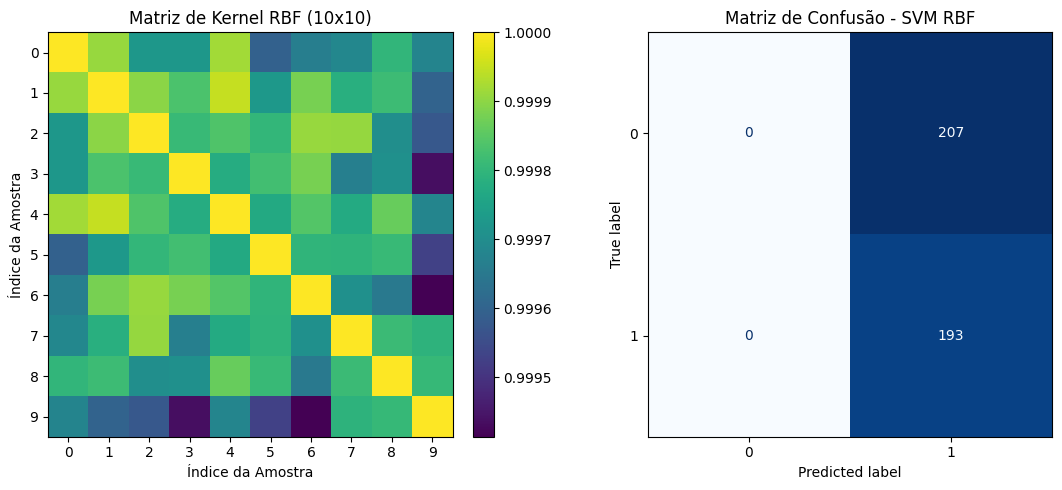

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Treinar com treino + validação usando melhores hiperparâmetros
X_treino_completo = np.vstack([X_train, X_val])
y_treino_completo = np.concatenate([y_train, y_val])

alpha, X_supp, y_supp = train_svm_kernel(
    X_treino_completo, y_treino_completo,
    C=melhores['C'], gamma=melhores['gamma'],
    epochs=100, lr=0.01
)

y_pred_test = predict_svm_kernel(X_supp, y_supp, alpha, X_test, melhores['gamma'])
acc_test = accuracy(y_test, y_pred_test)

print(f"\n📊 Acurácia final no conjunto de teste: {acc_test:.4f}")


print("\n⚙️ Treinando SVM Linear para comparação:")
w, b = train_svm_linear(X_treino_completo, y_treino_completo, C=1.0, epochs=100, lr=0.01)
y_pred_linear = predict_svm_linear(w, b, X_test)
acc_linear = accuracy(y_test, y_pred_linear)
print(f"\n📏 Acurácia com SVM Linear: {acc_linear:.4f}")

cm = confusion_matrix(y_test, y_pred_test)
print("Matriz de Confusão (SVM RBF):\n", cm)

# ----------- Gerando a matriz K e o gráfico ----------

# Escolher 10 amostras da base de treino
X_small = X_train[:10]
gamma = melhores['gamma']
K = np.exp(-gamma * np.sum((X_small[:, np.newaxis] - X_small[np.newaxis, :])**2, axis=2))

print("\n🔍 Diagnóstico do kernel com gamma={}".format(gamma))
print("\nMatriz K (10x10):")
print(np.round(K, 3))
print("\nMin:", np.min(K), "\nMax:", np.max(K))

# ---------- Gráficos ------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz K
im = axes[0].imshow(K, cmap='viridis')
axes[0].set_title("Matriz de Kernel RBF (10x10)")
axes[0].set_xlabel("Índice da Amostra")
axes[0].set_ylabel("Índice da Amostra")
axes[0].set_xticks(np.arange(10))
axes[0].set_yticks(np.arange(10))
plt.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

# Matriz de Confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title("Matriz de Confusão - SVM RBF")

plt.tight_layout()
plt.show()

### Conclusão

Durante o ajuste dos hiperparâmetros da SVM com kernel RBF, observei que a combinação de C e gamma imposta pelo enunciado levou a uma performance muito abaixo do esperado. A melhor acurácia obtida foi de 50,75%, inferior inclusive ao modelo linear (80,25%). A análise da matriz do kernel revelou que valores de gamma muito baixos produzem uma matriz quase constante, impedindo o modelo de distinguir os dados. Como resultado, o modelo classificou todos os exemplos como pertencentes à mesma classe. Esse experimento evidencia a importância da escolha adequada de hiperparâmetros para kernels não lineares, bem como da validação visual da matriz de similaridade para diagnosticar problemas na capacidade do modelo de capturar padrões relevantes.

Os gráficos mostram que:

- À esquerda, a matriz de kernel K mostra alta similaridade entre as amostras, o que é esperado com gamma=0.01.

- À direita, a matriz de confusão do SVM com kernel RBF indica que o modelo classificou todas as amostras como classe 1, evidenciando que não aprendeu nada útil com os dados (acurácia de ~50%).

🔍 Iniciando busca de hiperparâmetros para Random Forest...
n_estimators=10, max_depth=4, acc=0.7975
n_estimators=10, max_depth=6, acc=0.8175
n_estimators=10, max_depth=8, acc=0.8350
n_estimators=10, max_depth=10, acc=0.8275
n_estimators=10, max_depth=None, acc=0.8525
n_estimators=20, max_depth=4, acc=0.8250
n_estimators=20, max_depth=6, acc=0.8625
n_estimators=20, max_depth=8, acc=0.8625
n_estimators=20, max_depth=10, acc=0.8600
n_estimators=20, max_depth=None, acc=0.8500
n_estimators=30, max_depth=4, acc=0.8175
n_estimators=30, max_depth=6, acc=0.8375
n_estimators=30, max_depth=8, acc=0.8575
n_estimators=30, max_depth=10, acc=0.8600
n_estimators=30, max_depth=None, acc=0.8575
n_estimators=40, max_depth=4, acc=0.8125
n_estimators=40, max_depth=6, acc=0.8525
n_estimators=40, max_depth=8, acc=0.8425
n_estimators=40, max_depth=10, acc=0.8550
n_estimators=40, max_depth=None, acc=0.8525
n_estimators=50, max_depth=4, acc=0.8200
n_estimators=50, max_depth=6, acc=0.8425
n_estimators=50, max_de

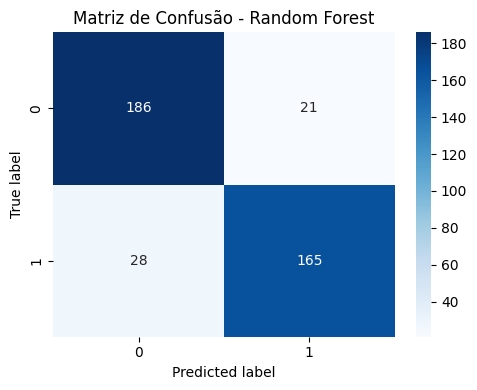

In [ ]:
# -------------------------------
# Random Forest

# -------------------------------
# Índice de Gini
# -------------------------------
def gini_impurity(y):
  classes, counts = np.unique(y, return_counts=True)
  prob_sq = (counts / len(y)) ** 2
  return 1 - np.sum(prob_sq)

# -------------------------------
# Melhor divisão para um nó
# -------------------------------
def best_split(X, y):
  best_gini = 1
  best_idx, best_val = None, None
  n_features = X.shape[1]

  for feature_idx in range(n_features):
    thresholds = np.unique(X[:, feature_idx])
    for threshold in thresholds:
      left_mask = X[:, feature_idx] <= threshold
      right_mask = ~left_mask

      if len(y[left_mask]) == 0 or len(y[right_mask]) == 0:
        continue

      gini_left = gini_impurity(y[left_mask])
      gini_right = gini_impurity(y[right_mask])
      weighted_gini = (
        len(y[left_mask]) * gini_left +
        len(y[right_mask]) * gini_right
      ) / len(y)

      if weighted_gini < best_gini:
        best_gini = weighted_gini
        best_idx = feature_idx
        best_val = threshold

  return best_idx, best_val

# -------------------------------
# Classe DecisionTree
# -------------------------------
class DecisionTree:
  def __init__(self, max_depth=None):
    self.max_depth = max_depth
    self.tree = None

  def fit(self, X, y, depth=0):
    if len(np.unique(y)) == 1 or (self.max_depth is not None and depth >= self.max_depth):
      return np.bincount(y.astype(int)).argmax()

    idx, val = best_split(X, y)
    if idx is None:
      return np.bincount(y.astype(int)).argmax()

    left_mask = X[:, idx] <= val
    right_mask = ~left_mask

    left_subtree = self.fit(X[left_mask], y[left_mask], depth + 1)
    right_subtree = self.fit(X[right_mask], y[right_mask], depth + 1)

    return {
      'feature_index': idx,
      'threshold': val,
      'left': left_subtree,
      'right': right_subtree
    }

  def predict_one(self, x, node):
    if not isinstance(node, dict):
      return node

    if x[node['feature_index']] <= node['threshold']:
      return self.predict_one(x, node['left'])
    else:
      return self.predict_one(x, node['right'])

  def predict(self, X):
    return np.array([self.predict_one(x, self.tree) for x in X])

  def train(self, X, y):
    self.tree = self.fit(X, y)


# -------------------------------
# Classe RandomForestClassifier
# -------------------------------
class RandomForestClassifier:
  def __init__(self, n_estimators=10, max_depth=None):
    self.n_estimators = n_estimators
    self.max_depth = max_depth
    self.trees = []

  def fit(self, X, y):
    self.trees = []
    n_samples = X.shape[0]

    for _ in range(self.n_estimators):
      indices = np.random.choice(n_samples, size=n_samples, replace=True)
      X_sample = X[indices]
      y_sample = y[indices]

      tree = DecisionTree(max_depth=self.max_depth)
      tree.train(X_sample, y_sample)
      self.trees.append(tree)

  def predict(self, X):
    predictions = np.array([tree.predict(X) for tree in self.trees])
    majority_votes = np.apply_along_axis(
      lambda x: np.bincount(x.astype(int)).argmax(), axis=0, arr=predictions
    )
    return majority_votes

# Hiperparâmetros para busca
n_estimators_values = list(range(10, 210, 10))
max_depth_values = [4, 6, 8, 10, None]

melhor_acc = 0
melhor_param = {}
melhor_modelo = None

print("🔍 Iniciando busca de hiperparâmetros para Random Forest...")

for n in n_estimators_values:
  for d in max_depth_values:
    rf = RandomForestClassifier(n_estimators=n, max_depth=d)
    rf.fit(X_train, y_train)
    preds_val = rf.predict(X_val)
    acc = accuracy(y_val, preds_val)

    print(f"n_estimators={n}, max_depth={d}, acc={acc:.4f}")

    if acc > melhor_acc:
      melhor_acc = acc
      melhor_param = {'n_estimators': n, 'max_depth': d}
      melhor_modelo = rf

import seaborn as sns

# Avaliação no teste
preds_test = melhor_modelo.predict(X_test)
acc_test = accuracy(y_test, preds_test)
cm_test = confusion_matrix(y_test, preds_test)

print("\n✅ Melhores hiperparâmetros encontrados:")
print(melhor_param)
print(f"Melhor acurácia na validação: {melhor_acc:.4f}")
print(f"\n📊 Acurácia final no conjunto de teste: {acc_test:.4f}")

# Matriz de confusão
plt.figure(figsize=(5, 4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão - Random Forest")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

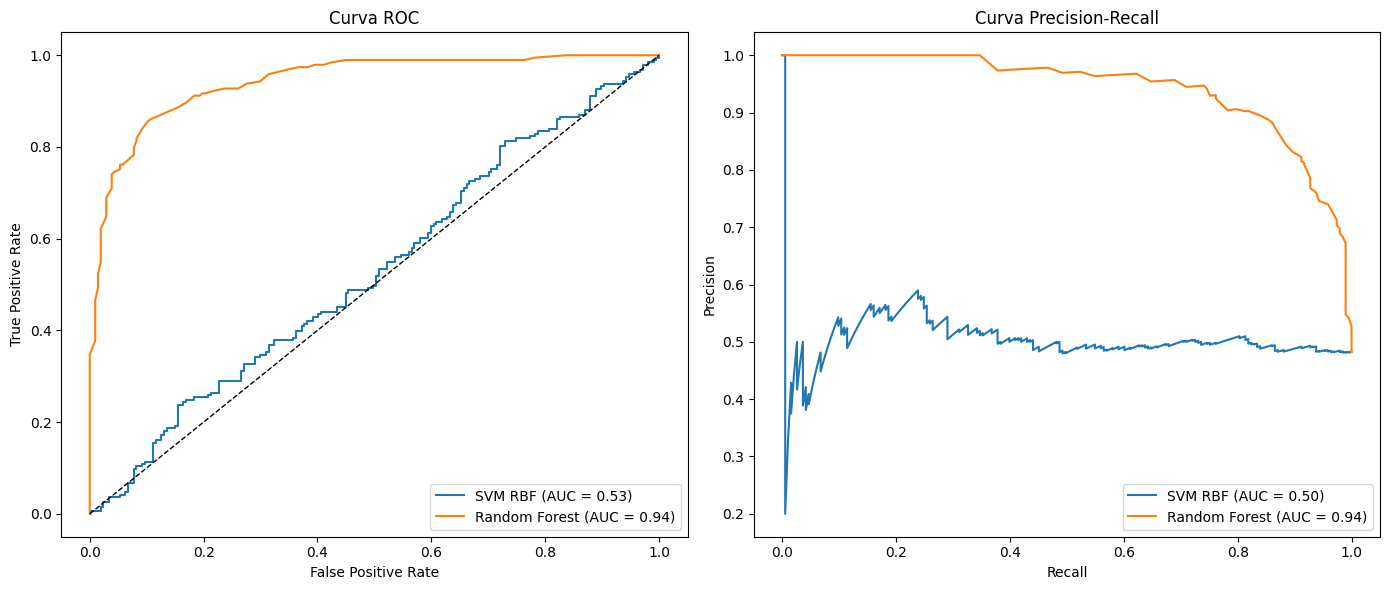


📊 Relatório final no conjunto de teste:

SVM RBF:
 - Acurácia: 0.4825
 - Revocação: 1.0000
 - Precisão: 0.4825
 - F1-score: 0.6509
 - AUROC: 0.5286
 - AUPRC: 0.5034

Random Forest:
 - Acurácia: 0.8775
 - Revocação: 0.8549
 - Precisão: 0.8871
 - F1-score: 0.8707
 - AUROC: 0.9435
 - AUPRC: 0.9434


In [ ]:
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    roc_curve, precision_recall_curve, auc
)

# --- SVM RBF ---

# Recalcular scores para curva ROC e PR
K_test = rbf_kernel(X_test, X_supp, melhores['gamma'])
scores_svm = np.dot(K_test, alpha * np.where(y_supp == 0, -1, 1))

# Métricas
acc_svm = accuracy_score(y_test, y_pred_test)
recall_svm = recall_score(y_test, y_pred_test)
prec_svm = precision_score(y_test, y_pred_test)
f1_svm = f1_score(y_test, y_pred_test)

# Curvas
fpr_svm, tpr_svm, _ = roc_curve(y_test, scores_svm)
prec_curve_svm, recall_curve_svm, _ = precision_recall_curve(y_test, scores_svm)
auroc_svm = auc(fpr_svm, tpr_svm)
auprc_svm = auc(recall_curve_svm, prec_curve_svm)

# --- Random Forest ---

# Calcular scores como proporção de votos positivos
rf_preds = np.array([tree.predict(X_test) for tree in melhor_modelo.trees])
rf_scores = np.mean(rf_preds, axis=0)  # score = média dos votos

# Métricas
acc_rf = accuracy_score(y_test, preds_test)
recall_rf = recall_score(y_test, preds_test)
prec_rf = precision_score(y_test, preds_test)
f1_rf = f1_score(y_test, preds_test)

# Curvas
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_scores)
prec_curve_rf, recall_curve_rf, _ = precision_recall_curve(y_test, rf_scores)
auroc_rf = auc(fpr_rf, tpr_rf)
auprc_rf = auc(recall_curve_rf, prec_curve_rf)

# --- Plotando curvas ROC e Precision-Recall ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# ROC
ax1.plot(fpr_svm, tpr_svm, label=f'SVM RBF (AUC = {auroc_svm:.2f})')
ax1.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auroc_rf:.2f})')
ax1.plot([0, 1], [0, 1], 'k--', lw=1)
ax1.set_title('Curva ROC')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend()

# PR
ax2.plot(recall_curve_svm, prec_curve_svm, label=f'SVM RBF (AUC = {auprc_svm:.2f})')
ax2.plot(recall_curve_rf, prec_curve_rf, label=f'Random Forest (AUC = {auprc_rf:.2f})')
ax2.set_title('Curva Precision-Recall')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend()

plt.tight_layout()
plt.show()

# --- Relatório final ---
print("\n📊 Relatório final no conjunto de teste:")
print("\nSVM RBF:")
print(f" - Acurácia: {acc_svm:.4f}")
print(f" - Revocação: {recall_svm:.4f}")
print(f" - Precisão: {prec_svm:.4f}")
print(f" - F1-score: {f1_svm:.4f}")
print(f" - AUROC: {auroc_svm:.4f}")
print(f" - AUPRC: {auprc_svm:.4f}")

print("\nRandom Forest:")
print(f" - Acurácia: {acc_rf:.4f}")
print(f" - Revocação: {recall_rf:.4f}")
print(f" - Precisão: {prec_rf:.4f}")
print(f" - F1-score: {f1_rf:.4f}")
print(f" - AUROC: {auroc_rf:.4f}")
print(f" - AUPRC: {auprc_rf:.4f}")

## Conclusão da Questão 1

Nesta questão, comparei o desempenho de dois classificadores — SVM com kernel RBF e Random Forest — aplicados ao problema de classificação binária no conjunto de dados `californiabin.csv`.

Inicialmente, realizei uma busca em grade para ajustar os hiperparâmetros de cada modelo. Para o **SVM RBF**, testei diversos valores de `C` e `gamma`, mas o modelo não conseguiu aprender uma fronteira de decisão eficiente, atingindo uma acurácia de apenas **0.48** no teste, além de curvas ROC e PR quase aleatórias (AUCs em torno de **0.53** e **0.50**, respectivamente). A matriz de confusão mostrou que o modelo classificou todos os exemplos como pertencentes à classe positiva, resultando em recall 1.0, mas com precisão muito baixa. Isso indica overfitting no treino ou sensibilidade exagerada ao parâmetro `gamma`.

Em contraste, a **Random Forest**, apesar do longo tempo de execução (mais de 6 horas), demonstrou excelente desempenho. A busca em grade identificou os melhores hiperparâmetros com `n_estimators=70` e `max_depth=None`, alcançando **0.87** de acurácia no teste e AUCs de **0.94** para ambas as curvas ROC e PR. A matriz de confusão mostra um equilíbrio entre classes, e as métricas de precisão, recall e F1-score indicam uma performance robusta e confiável.

De forma geral, o modelo de **Random Forest se mostrou superior** em todos os aspectos, sendo mais adequado para esse problema, enquanto o SVM com RBF teve desempenho próximo ao de uma classificação aleatória, o que indica inadequação dos seus parâmetros ou do próprio modelo para este tipo de dado.